In [1]:
from src import host
from src import common
from src.setup import *
%load_ext autoreload
%autoreload 2

# Introduction

One can run this notebook with `src/run_gwas.sh` since some computations take a long time (this is faster than running this notebook interactively by using ipcluster, and it is easier to manage resources allocation). This executes the notebook and store the results in a new notebook. 

###### A word about `run_gwas()` function

Every output is stored. Warnings are displayed in `concatenated_warnings`, and the log files are assembled and stored in `concatenated_logs` (both paths are defined in `setup.py`).

# Compute assciation tests



In [2]:
#host.run_gwas()

# Check the results

###### Report computational time


In [3]:
!cat $PATH_ASIANS_GWAS_TMP_LOGS_CONCAT | grep "Start time:" | head -1 
!cat $PATH_ASIANS_GWAS_TMP_LOGS_CONCAT | grep "End time:" | tail -1 

Start time: Tue Aug 20 18:20:28 2019
grep: erreur d'écriture
cat: erreur d'écriture: Relais brisé (pipe)
End time: Tue Aug 20 18:38:07 2019


This took about 18 min 30 s.

###### Look at warnings



In [4]:
# count warnings
print("Number of warnings: ", end='')
!grep $PATH_ASIANS_GWAS_TMP_LOGS_CONCAT -e Warning | wc -l

Number of warnings: 633


In [6]:
!head -3 $PATH_ASIANS_GWAS_TMP_WARNINGS


(PC_9_V) Warning: --glm remaining case count is less than 10x predictor count for
phenotype 'PC_9_V'.


We have 633/744 amino acids that do not respect the 1 to 10 rule of the thumb.

###### Skipped amino acids


In [6]:
!grep $PATH_ASIANS_GWAS_TMP_WARNINGS -e Skipping | wc -l

37


We have 37 amino acids that were skipped with the following warning:

    (S_19_P) Warning: Skipping --glm regression on phenotype <AA> since # samples <= #
    predictor columns.
    (Quasi-)separated covariate(s) were present.  Try removing inappropriate
    covariates, and/or using Firth logistic regression.

# Summarize & filter results

## Compute p-value summaries and filter with threshold

For each amino acid:

* We filter results with the threshold, add a column with the amino acid reference and concatenate the results
* We generate summary statistics for the p-values (SNPs + covariates) and include it as a column (the column name being the amino acid reference) in a table
* We generate summary statistics for the p-values of the SNPs (no covariates included)

**Warning: this takes a while (> 30 min).**

In [7]:
# 1. Get all files in the temporary results directory
from os import walk
f = []
for (dirpath, dirnames, filenames) in walk(PATH_ASIANS_GWAS_TMP):
    f = filenames    

In [101]:
threshold = 5e-8

In [9]:
# 2. For each plink report file, get p-values and summarize them
summaries = pd.DataFrame()
summaries_snps = pd.DataFrame()
concat = pd.DataFrame()
for i in f:
    if i[-9:] != '.logistic': continue 
    print('.', end='')
    df = pd.read_csv(PATH_ASIANS_GWAS_TMP+i, sep='\t')
    # Summary statistics of all p-values
    summary = df.P.describe()
    summary.name = i.split('.')[1]
    # Summary statistics of p-values related to SNPs additive effects
    summary_snps = df[ df.TEST == 'ADD' ].P.describe()
    summary_snps.name = i.split('.')[1]
    # New dataset with significant p-values (additive effects + covariates)
    filtered = df[ df.P <= threshold ] 
    filtered['AA'] = [i.split('.')[1]] * filtered.shape[0]
    if summaries.empty: 
        summaries = pd.DataFrame(summary)
        summaries_snps = pd.DataFrame(summary_snps)
        concat = pd.DataFrame( filtered )
    else: 
        summaries.insert(loc=0, column=i.split('.')[1], value=summary)
        summaries_snps.insert(loc=0, column=i.split('.')[1], value=summary_snps)
        concat = concat.append(filtered, ignore_index=True)
print()

..

/home/mazeller/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [10]:
# 3. Save the results
common.write_binary(PATH_ASIANS_GWAS_TMP_SUMMARY, summaries)
common.write_binary(PATH_ASIANS_GWAS_FILTERED, concat)
common.write_binary(PATH_ASIANS_GWAS_TMP_SUMMARY_SNPS, summaries_snps)

write_binary(): successfully written in 'data/plink/gwas/pval_summary'
write_binary(): successfully written in 'data/plink/gwas/filtered_g2g'
write_binary(): successfully written in 'data/plink/gwas/pval_summary_snps'


## Statistics on SNP-p-value summaries

In [3]:
with open(PATH_ASIANS_GWAS_TMP_SUMMARY_SNPS, 'rb') as file:
    df = pickle.load(file)

In [33]:
print("Summary statistics for additive effects of SNPs, grouped by amino acid:")
df.loc[:, np.random.choice(df.columns.values, size=6)]

DataFrame containing statistic summaries of p-values for every amino acid that was tested:


,Pol_617_E,Pol_206_P,PC_108_P,Pol_624_I,S_114_N,S_230_P
count,154760.000000,163990.000000,34.000000,28274.000000,9932.000000,763.000000
mean,0.494626,0.495551,0.363614,0.454594,0.654745,0.991211
std,0.281275,0.290087,0.330374,0.268580,0.252537,0.022060
min,0.000098,0.000044,0.003333,0.000114,0.006030,0.890236
25%,0.252816,0.241494,0.067961,0.229965,0.493756,0.996659
50%,0.488282,0.493717,0.256824,0.427179,0.707108,0.998154
75%,0.733023,0.746613,0.649933,0.665216,0.860763,0.999240
max,0.999997,0.999999,0.965263,0.999884,0.999963,1.000000


Now we make summary statistics of the summary statistics... For each summary statistic of the table above, we compute the summary statistics among all amino acids (we compute statistics for each row of the table, those will be inserted as columns in the table below).

In [38]:
df_summary = pd.DataFrame(df.loc['mean'].describe())
rows = ['std', 'min', '25%', '50%', '75%', 'max']
for r in rows:
    df_summary[r] = df.loc[r].describe()
df_summary.drop('count', axis=0, inplace=True)
df_summary

,mean,std,min,25%,50%,75%,max
mean,0.523212,0.250829,1.003225e-01,0.317075,0.511991,0.724496,0.973434
std,0.183638,0.083681,2.748930e-01,0.243611,0.199840,0.164530,0.129062
min,0.025849,0.000000,1.947920e-13,0.013235,0.025849,0.025849,0.025849
25%,0.484316,0.269889,1.922910e-05,0.229926,0.474882,0.731825,0.999958
50%,0.492665,0.286613,8.511255e-05,0.242587,0.488228,0.741184,0.999992
75%,0.509177,0.289439,2.328043e-03,0.271306,0.506736,0.751404,0.999997
max,0.998267,0.386736,9.982670e-01,0.998267,0.999365,0.999704,1.000000


Explanation for the `mean` *column*: for each amino acids, we made a list of the p-values that were related to the tested SNPs (excluding covariates). This list thus has a length that is equal to the number of amino acids. Now we compute summary statistics for this list (each of these statistics is a row in the table above), thus we summarize the mean p-value for all SNPs among every amino acid.

For instance, we observe that
* the most significantly association ever observed in the analysis between a SNP and an amino acid (row `min`, column `min`) has a p-value of `1.947920e-13`

In [69]:
df_plot = df.transpose().drop('count', axis=1)

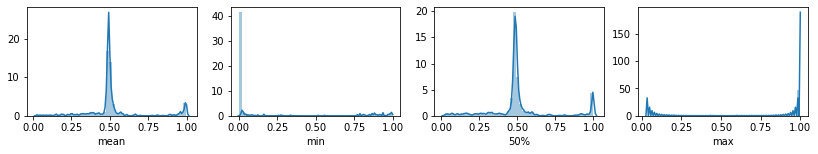

In [81]:
boxes = ['mean', 'min', '50%', 'max']
fig, ax = plt.subplots(1, len(boxes), figsize=(14,2))
for i, b in enumerate(boxes):
    sns.distplot(df_plot[b].dropna(), ax=ax[i])

# Analysis of filtered results

Here, we want to investigate the most significant associations in the results that were filtered by the threshold defined above.

###### Plan

* See which variables (and covariates) have the biggest number of associations
* Investigate the associations for the additive effects

In [3]:
# Load the filtered results
# Pay attention to the RAM available, it's a big file (about 2Go)
with open(PATH_ASIANS_GWAS_FILTERED, 'rb') as file:
    df_results = pickle.load(file)

In [50]:
# See how it looks like
print("Shape of the DataFrame:", df_results.shape)
df_results.head(2)

Shape of the DataFrame: (20247946, 13)


,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,AA
0,1,14677,rs201327123,G,A,A,VPC1,397,0.586538,0.080103,-6.66038,2.731220e-11,S_179_T
1,1,14933,rs199856693,G,A,A,VPC1,433,0.629773,0.062398,-7.41044,1.258810e-13,S_179_T


In [53]:
aa_counts = df_results.AA.value_counts()
print("There are {} different amino acids that contain at least 1 significant association (variable or covariate)"
     .format(len(aa_counts)))

There are 223 amino acids that contain at least 1 significant association (variable or covariate)


## Rate of significant associations for each variable of the model

In [51]:
df_results.TEST.value_counts()

VPC1    10748966
VPC5     4038924
VPC6     2752348
VPC2     2529906
VPC3      161430
VPC4       15975
ADD          318
AGE           78
HPC3           1
Name: TEST, dtype: int64

We observed **318 significant associations** between a SNP and an amino acid at the $5*10^{-8}$ level (this is represented by the keyword `ADD`, for additive effects).

## Associations SNP<->AA

In [4]:
# Among the filtered results, keep only the tests done on the additive effects of SNPs
df_snps = df_results[ df_results.TEST == 'ADD' ]
df_snps.shape

(318, 13)

In [5]:
# Number of associated SNP for each amino acid
add_effect_aa_count = df_snps.AA.value_counts()
add_effect_aa_count

PC_160_A     213
PC_160_P      64
Pol_49_N      21
PC_142_D      14
Pol_584_T      2
Pol_215_Q      1
S_45_F         1
S_51_P         1
S_35_R         1
Name: AA, dtype: int64

In [6]:
# Number of associated amino acid for every SNP
add_effect_snp_count = df_snps.ID.value_counts()
add_effect_snp_count

rs2296651         3
rs400488          2
rs17187523        2
rs2735101         2
rs5875224         2
                 ..
6:29770087:A:C    1
rs58449426        1
rs10947088        1
rs41554316        1
rs2076180         1
Name: ID, Length: 252, dtype: int64

In [7]:
print("Among all significant associations tested between the additive effect of SNPs and the viral \
amino acids, we count:\n- {} amino acids\n- {} SNPs\nFor a total of {} associations."
      .format(len(add_effect_aa_count), len(add_effect_snp_count), add_effect_snp_count.sum()))

Among all significant associations tested between the additive effect of SNPs and the viral amino acids, we count:
- 9 amino acids
- 252 SNPs
For a total of 318 associations.


## Manhattan plots

We generate manhattan plots for all of the 9 associated amino acids. Since we are interested only in the additive effects of SNPs, we create a new filtered file for each of the 9 amino acid.

In [8]:
# 1. Get a list of those AAs
aa_list = add_effect_aa_count.index.values
# 2. Get the paths to the raw files for each aa
path_list = [ PATH_ASIANS_GWAS_TMP_RESULTS + '.' + aa + '.glm.logistic' for aa in aa_list ]

In [9]:
# 3. Create new files where column TEST == 'ADD' and get the file paths
filtered_path = []
for f in path_list:
    filtered_path.append(host.extract_ADD(f, PATH_SIGNIFICANT_AAS))

.........

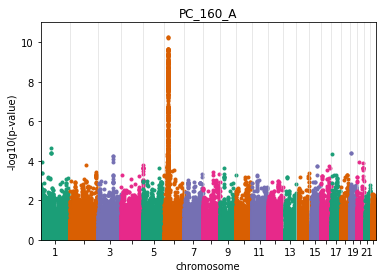

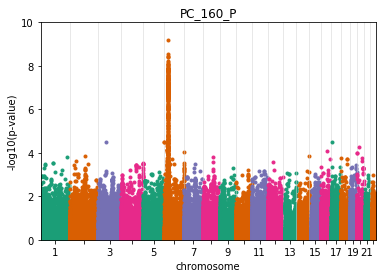

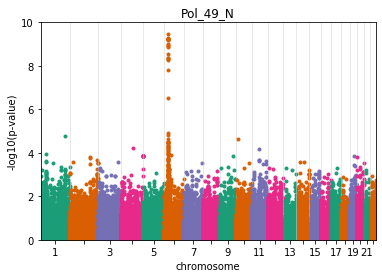

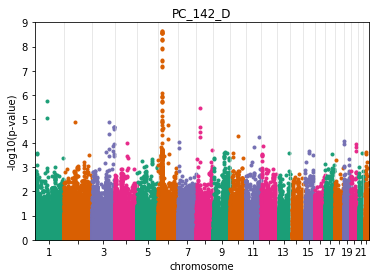

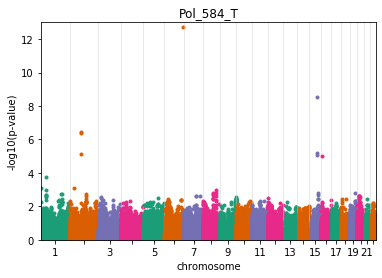

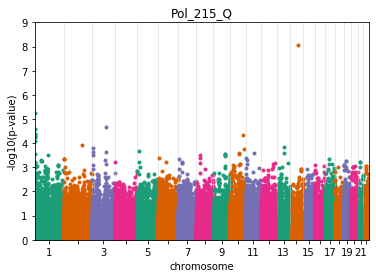

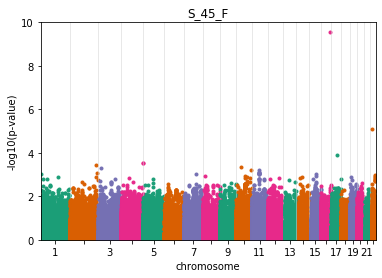

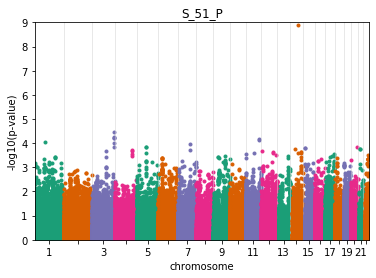

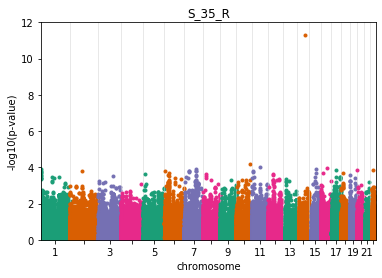

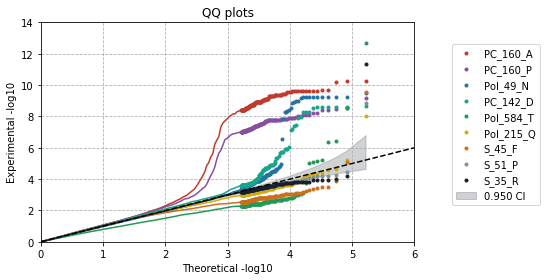

In [10]:
import warnings
warnings.filterwarnings('ignore')
host.gen_manhattan(filtered_path)

# Threshold reconsideration

The threshold of $5*10^{-8}$ is a common value used in GWASs. However, we have to take into account that we made tests for each amino acid. Using Bonferroni would lead to a very conservative model and would probably be unable to detect any association. [This article](https://onlinelibrary.wiley.com/doi/abs/10.1002/gepi.20310) suggests to implement a new method to correct for multiple testing. The implementation is inspired by [this R code](https://github.com/sinarueeger/GWAS.utils/blob/master/R/eff_nbr_tests.R). The methods has the following step:

1. Recode the alleles with 0, 1, 2
    * 0: variant-type allele homozygotes
    * 1: WT allele heterozygotes
    * 2: WT allele homozygotes
1. Compute the composite LD correlation matrix from the SNP dataset
1. Compute the eigenvalues
1. Infer the number of effective tests (number of independent tests) through PCA
1. Apply Bonferroni with the number of effective tests

As the HBV is haploid, we can't code alleles as 0, 1, 2. So we'll simply use 0 and 1 code. 


In [5]:
# 1. Load the viral data
with open(PATH_VIRAL_DATA, 'rb') as file:
    df = pickle.load(file) 
df.drop(('id', '', ''), inplace=True, axis=1)
df_float = df.astype(float)
# 2. Compute correlation matrix
corr = df_float.corr()

In [6]:
# 3. Singular value decomposition
_, s, _ = np.linalg.svd(corr)

In [7]:
# 4. Compute the number of singular values to reach 99.5%
reach = 0.995
S = np.sum(s) 
i = 0
while np.sum(s[0:i+1]) / S < reach :
    i += 1
# Check
print(i)
print(np.sum(s[0:i])/S)
print(np.sum(s[0:i+1])/S)

406
0.994991914728406
0.9950503166998801


In [8]:
adj_threshold = 5e-8 / i 
adj_threshold

1.231527093596059e-10

## Re-filter with the adjusted threshold

From `df_results`, we keep only the additive effects and the p-values that are under the new threshold.

In [9]:
df_sig_add = df_results[ df_results.P <= adj_threshold ]
df_sig_add = df_sig_add[ df_sig_add.TEST == 'ADD' ]
print(df_results.shape, '->', df_sig_add.shape)

(20247946, 13) -> (5, 13)


In [19]:
df_hits = df_sig_add.set_index('ID')
# Store the results
with open(PATH_GWAS_FINAL_RESULTS, 'w') as file:
    file.write(df_hits.to_csv(sep='\t'))
df_hits

,#CHROM,POS,REF,ALT,A1,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,AA
ID,,,,,,,,,,,,
rs2296651,14,70245193,G,A,A,ADD,434,4.814160e+01,0.560362,6.91365,4.723260e-12,S_35_R
rs9397998,6,157488340,C,T,T,ADD,431,1.711340e+09,2.891680,7.35232,1.947920e-13,Pol_584_T
rs70944751,6,29911857,G,T,T,ADD,430,4.000960e-02,0.490586,-6.56080,5.352000e-11,PC_160_A
rs376806238,6,29912395,T,TGG,TGG,ADD,413,5.556070e-03,0.793047,-6.54799,5.831780e-11,PC_160_A
rs2735101,6,29913001,T,C,C,ADD,429,1.258320e-02,0.669145,-6.53878,6.202110e-11,PC_160_A


## Save the significant amino acids

We can permanently and automatically store the significantly associated amino acids.

In [37]:
# 1. Load the list of amino acids
aa_list = df_sig_add.AA.value_counts().index.values
# 2. Copy the files from tmp folder to permanent folder
for aa in aa_list:
    filename = PATH_ASIANS_GWAS_TMP_RESULTS+'.'+aa+'.glm.logistic'
    !cp -v $filename $PATH_GWAS_RESULTS

‘/scratch/mazeller/gwas_tmp_results/asians_gwas.PC_160_A.glm.logistic’ -> ‘data/plink/gwas/asians_gwas.PC_160_A.glm.logistic’
‘/scratch/mazeller/gwas_tmp_results/asians_gwas.Pol_584_T.glm.logistic’ -> ‘data/plink/gwas/asians_gwas.Pol_584_T.glm.logistic’
‘/scratch/mazeller/gwas_tmp_results/asians_gwas.S_35_R.glm.logistic’ -> ‘data/plink/gwas/asians_gwas.S_35_R.glm.logistic’


# Analyse of results

## Viral subtypes of the individuals

In [137]:
# 1. Load clinical data
with open(PATH_CLINICAL_DATA, 'rb') as file:
    df = pickle.load(file)
df = df[['IGM_ID', 'GT']]
df.set_index('IGM_ID', inplace=True)

In [133]:
# 2. Load the ids used in the study
df_subsample = pd.read_csv(PATH_ASIANS_GWAS+'.fam', sep='\t', header=None)
df_subsample = df_subsample.join(other=df, on=0)

In [144]:
# 3. See the distribution of the viral genotypes
df_subsample.GT.value_counts()

C                          314
B                           97
D                           15
A                            7
Mixed                        1
G                            1
Mixed genotype detected      0
H                            0
F                            0
E                            0
Name: GT, dtype: int64

## Exporting the specific SNPs



In [23]:
snp_list = df_sig_add.ID.values
plink_lst = ""
for snp in snp_list:
    plink_lst += ',' + snp
plink_lst = plink_lst[1:] # remove the first comma
plink_lst

'rs2296651,rs9397998,rs70944751,rs376806238,rs2735101'

In [27]:
host.run_plink("--snps "+plink_lst+" --recode", file=PATH_ASIANS_GWAS, extension=' ',
               out=PATH_ASIANS_GWAS+"_sig", plink2=False, log_name='asians_gwas_7_extract_snps');

Running 'plink --bfile data/plink/asians_gwas --out data/plink/asians_gwas_sig --snps rs2296651,rs9397998,rs70944751,rs376806238,rs2735101 --recode '
Log written to 'data/plink/log/asians_gwas_7_extract_snps.log'


# Manhattan plots of significantly associated AAs

In [29]:
df_hits = pd.read_csv(PATH_GWAS_FINAL_RESULTS, sep='\t')
# The additive effects were already extracted when manhattan plots were generated,
# before the threshold was reconsidered
path_aa_additive_effects = [ PATH_ASIANS_GWAS_RESULTS + "." + aa + '.glm.logistic.ADD' 
                            for aa in df_hits.AA.value_counts().index.values ]

In [30]:
path_aa_additive_effects

['data/plink/gwas/asians_gwas.PC_160_A.glm.logistic.ADD',
 'data/plink/gwas/asians_gwas.S_35_R.glm.logistic.ADD',
 'data/plink/gwas/asians_gwas.Pol_584_T.glm.logistic.ADD']

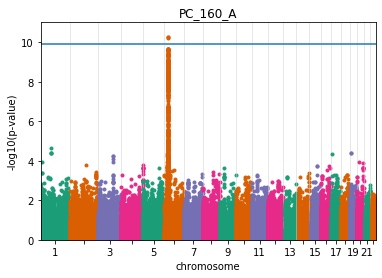

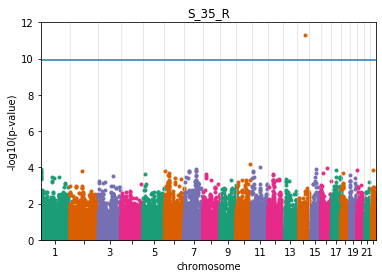

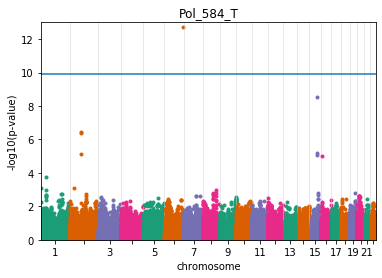

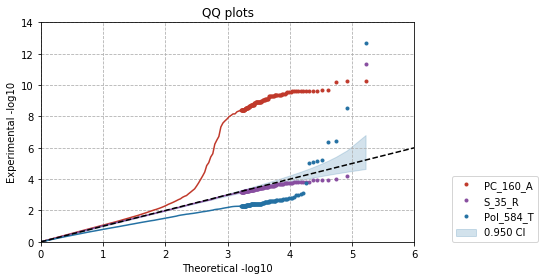

In [31]:
import warnings
warnings.filterwarnings('ignore')
path_list = [  ]
host.gen_manhattan(path_aa_additive_effects, threshold=1.231527093596059e-10)